In [221]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from anndata import AnnData


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.2.2 anndata==0.6.6 numpy==1.14.0rc1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


### Import csv files

Two files were given - one has 1738 cells and the other has 664 cells. Reading the files into dataframes

In [222]:
data_rep1 = pd.read_csv('GSM2743164_rep1_colon_rnaseq.csv', header=0, index_col=0)
data_rep2 = pd.read_csv('GSM2743165_rep2_colon_rnaseq.csv', header=0, index_col=0)

### Preprocessing

In [223]:
#Concatenating into one dataframe
data_concat = pd.concat([data_rep1, data_rep2], axis=1)

# Cells should be rows and genes should be columns, so need to transpose the dataframe
data_concat = data_concat.T

#Convert the dataframe to an AnnData data structure, which is needed to do the rest of the scanpy analyses
adata = AnnData(X=data_concat.values)
adata.obs_names = data_concat.index #cell names
adata.var_names = data_concat.columns #gene names

Checking the dimensions of the initial AnnData object, can compare with filtered object later

In [224]:
adata

AnnData object with n_obs × n_vars = 2402 × 25504 

Made batch1/batch 2 metadata to check for batch effects later

In [225]:
batch1 = np.array(["batch1" for i in range(data_rep1.shape[1])])
batch2 = np.array(["batch2" for i in range(data_rep2.shape[1])])
adata.obs['batch'] = np.concatenate((batch1, batch2))

QC: Only keep cells with >200 genes and check how many cells were filtered out

In [226]:
sc.pp.filter_cells(adata, min_genes=200)
adata

AnnData object with n_obs × n_vars = 2402 × 25504 
    obs: 'batch', 'n_genes'

Plot some information about mitochondrial genes, important for quality control. 

In [227]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)


... storing 'batch' as categorical


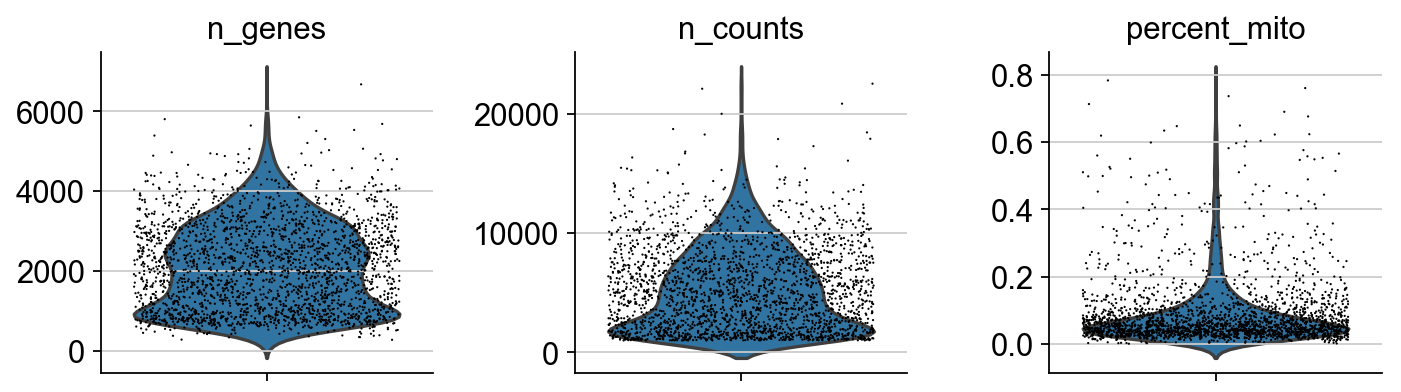

In [228]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

QC: Remove cells that have too many mitochondrial genes expressed or too many total counts (doublets?).



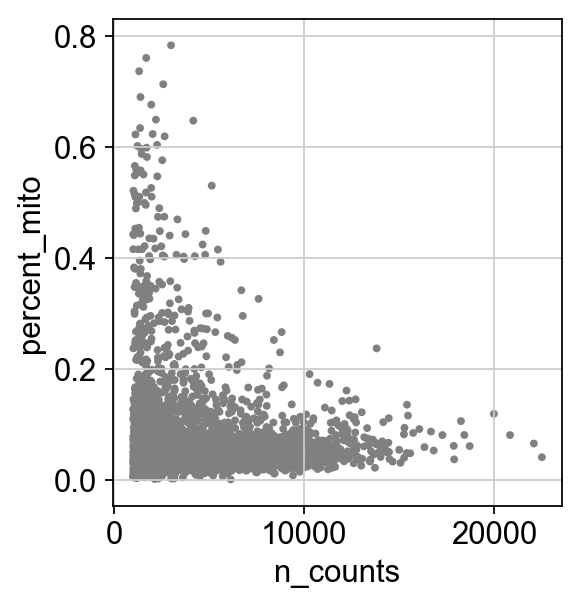

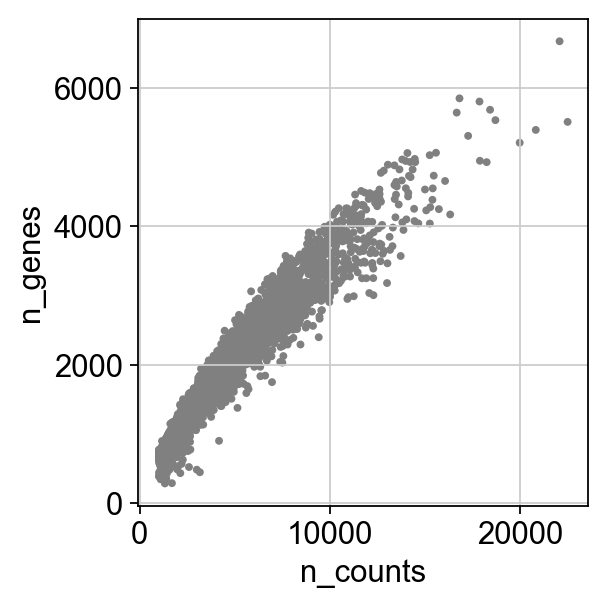

In [229]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Not actually filtering out anything for now since I'm looking for rare cell types...can uncomment if I want to be more stringent about filtering later

In [230]:
# Filtering
#adata = adata[adata.obs['n_genes'] < 2500, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p.

In [231]:
adata.raw = sc.pp.log1p(adata, copy=True)

Normalize data matrix by cell (total cells = 10,000)

In [232]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly variable genes. Played with the min_disp until I got under 2000 genes. Jose says that too many genes makes clustering impossible. 

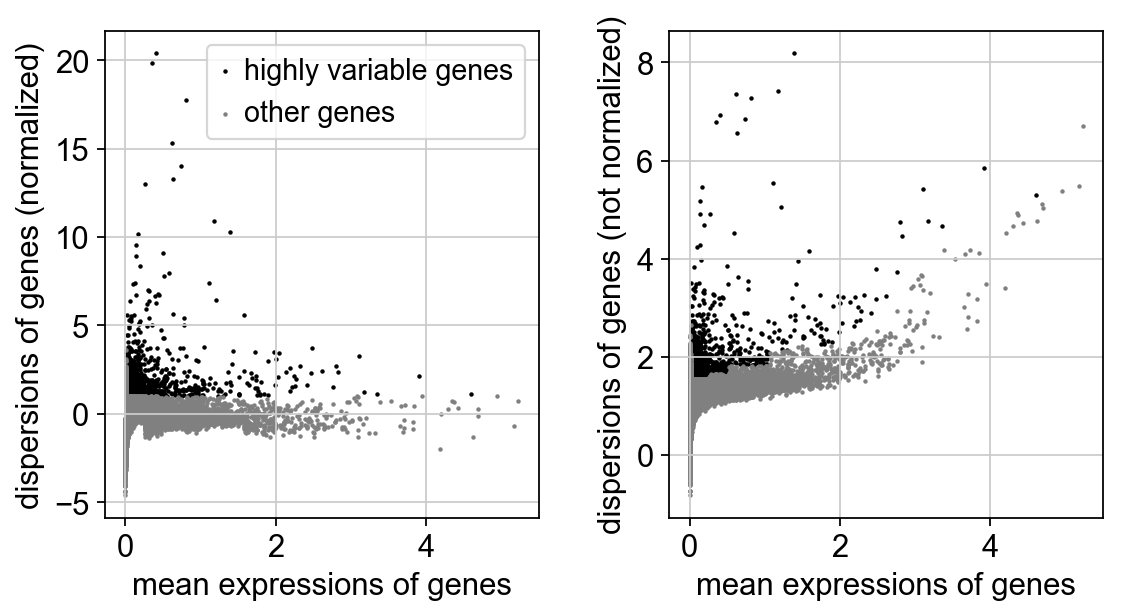

In [233]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=10, min_disp=1)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [234]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [235]:
sc.pp.log1p(adata)

In [236]:
adata

View of AnnData object with n_obs × n_vars = 2402 × 1639 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'

In [237]:
sc.pp.scale(adata, max_value=10)

### PCA

In [238]:
sc.tl.pca(adata)

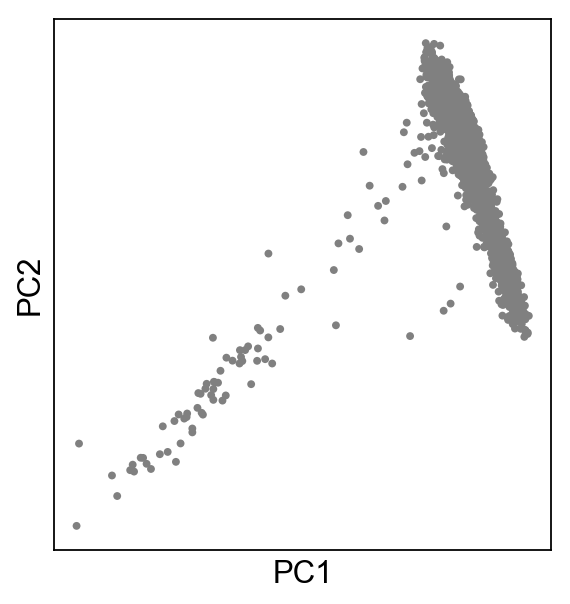

In [239]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata)

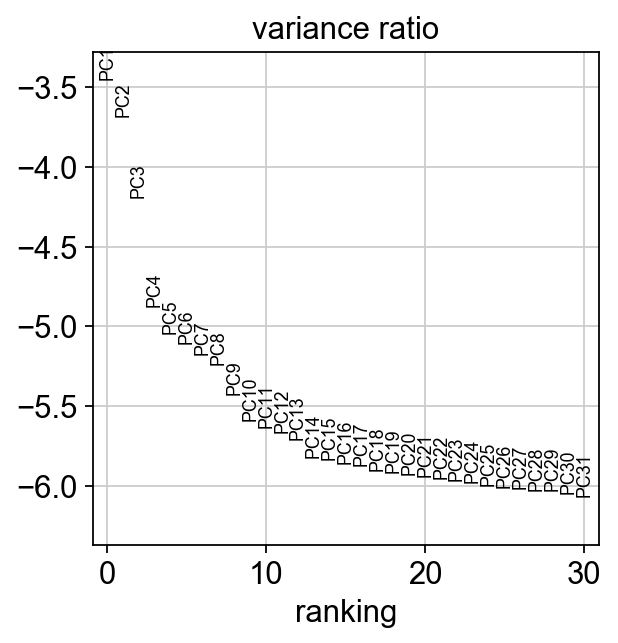

In [240]:
sc.pl.pca_variance_ratio(adata, log=True)

Check what genes are contributing to PCs

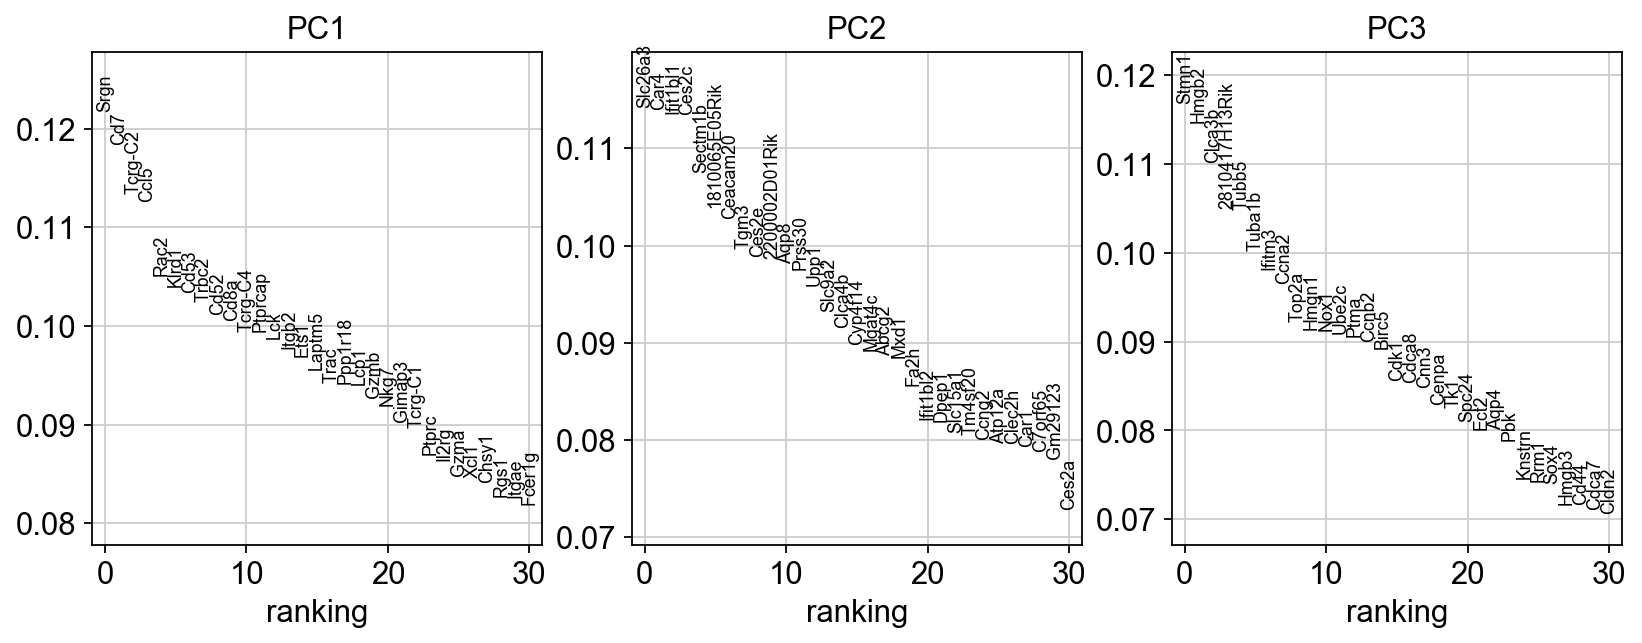

In [241]:
sc.pl.pca_loadings(adata)

### tSNE

In [242]:
sc.tl.tsne(adata, random_state=2, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:59.82) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


Check different colon epithlium markers in tSNE plot, plus color by batch to check if there are batch effects

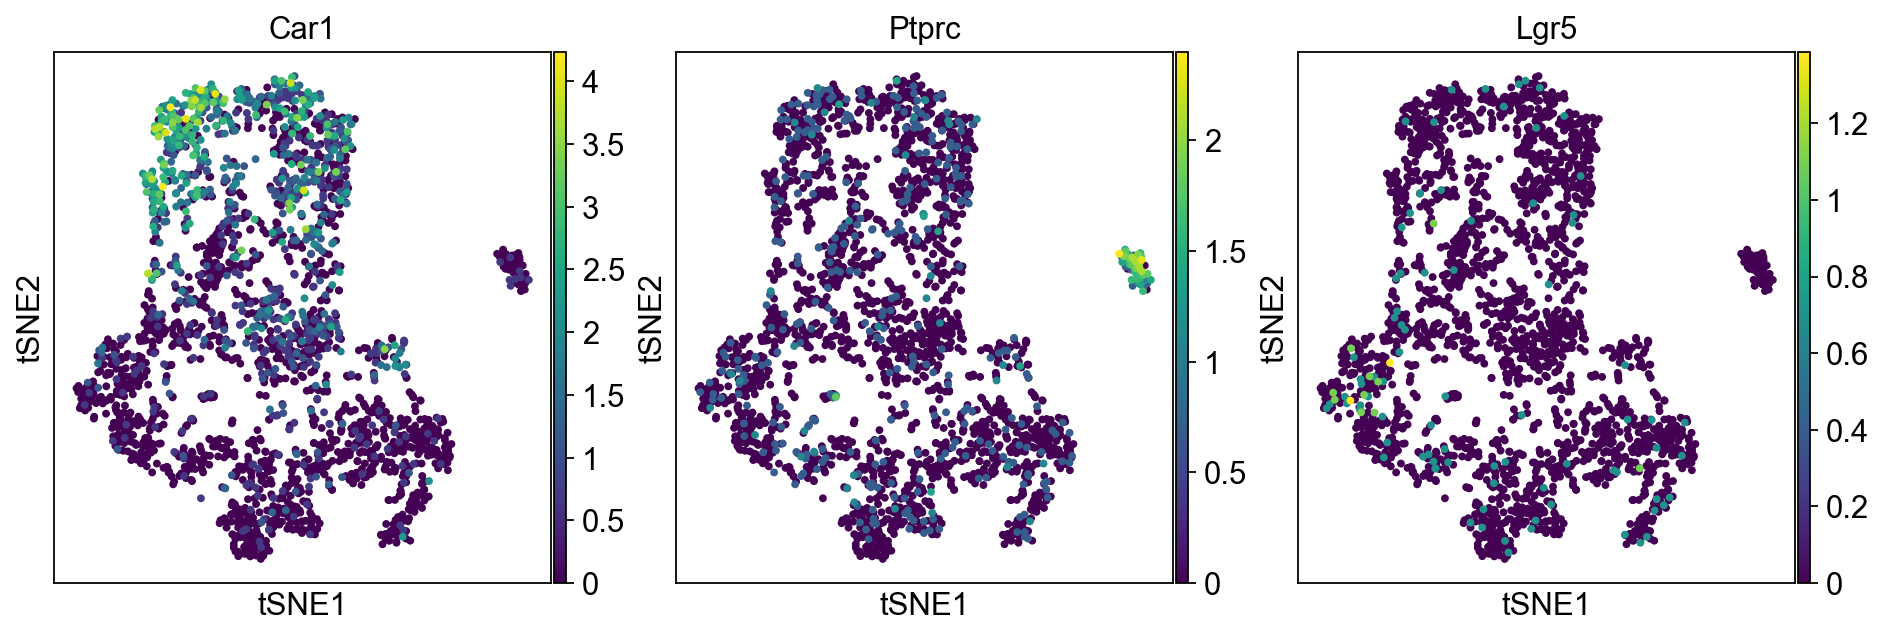

In [ ]:
sc.pl.tsne(adata, color=['Car1','Ptprc','Lgr5'])
sc.pl.tsne(adata, color=['Muc2','Chga','batch'])

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10)

My understanding is that UMAP is similar to tSNE, just faster

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='Chga')

### Clustering

In [ ]:
sc.tl.louvain(adata)

Plot the data with tSNE. Coloring according to clustering.

In [ ]:
sc.pl.tsne(adata, color='louvain')

In [ ]:
sc.pl.umap(adata, color='louvain')

### Finding marker genes

Ranking genes with t-test

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20)

Rank genes with logistic regression, which has been shown to be better

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, save=".pdf")

Look at top genes in each cluster

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

Checking if any clusters have enteroendocrine cells...looks like not? :/ 

In [ ]:
sc.pl.violin(adata, ['Chga'], groupby='louvain')